In [ ]:
from serial.tools.list_ports import comports
for port in comports():
    print(port)

In [2]:
import subprocess

def check_git_status():
    try:
        # Check if the local branch is up to date with the remote branch
        result = subprocess.run(['git', 'remote', 'update'], capture_output=True, text=True)
        result = subprocess.run(['git', 'status', '-uno'], capture_output=True, text=True)
        if "Your branch is up to date" in result.stdout:
            print("Code is up to date with the remote repository.")
        elif "Your branch is behind" in result.stdout:
            print("!!!!!!!!!!!!! There are changes in the remote repository that are not in the local repository. !!!!!!!!!!!!!")
        elif "Your branch is ahead" in result.stdout:
            print("!!!!!!!!!!!!! The local repository is ahead of the remote repository. !!!!!!!!!!!!!")
        else:
            print("The local repository has diverged from the remote repository.")
    except Exception as e:
        print(f"An error occurred while checking the git status: {e}")

# Check the git status
check_git_status()


The local repository is up to date with the remote repository.


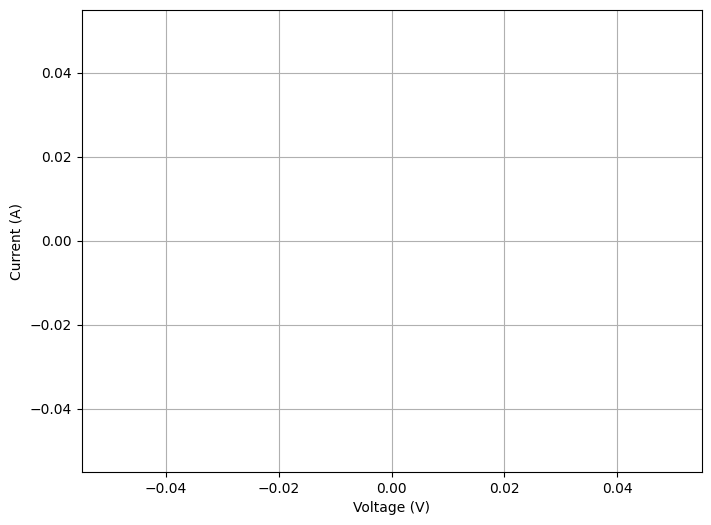

In [2]:
import os
import sys
import time
import csv
import numpy as np
import threading
import queue
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import serial
import serial.tools.list_ports
from Keithley617 import Keithley617 as smu

class JVMeasurementApp:
    def __init__(self, master):
        self.master = master
        master.title("ScanDor JV Measurement")

        # Measurement parameters
        self.start_voltage = tk.DoubleVar(value=0)
        self.end_voltage = tk.DoubleVar(value=10)
        self.step_size = tk.DoubleVar(value=1)
        self.scan_rate = tk.DoubleVar(value=1)
        self.use_std_check = tk.BooleanVar(value=True)
        self.sample_number = tk.IntVar(value=5)
        self.max_samples = tk.IntVar(value=30)
        self.std_threshold = tk.DoubleVar(value=0.1)
        self.file_name = tk.StringVar(value="measurement_data")
        self.output_directory = tk.StringVar(value=os.getcwd())
        self.selected_port = tk.StringVar()
        self.sweep_mode = tk.StringVar(value='Directional Sweep')
        self.num_cycles = tk.IntVar(value=1)  # For Hysteresis mode
        self.constant_voltage = tk.DoubleVar(value=0)  # For Constant Voltage mode
        self.constant_runtime = tk.DoubleVar(value=10)  # For Constant Voltage mode runtime

        # Data arrays
        self.times = []
        self.currents = []
        self.voltages = []

        # Instrument
        self.instrument = None  # Will hold the smu instance after connection

        # Matplotlib Figure
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.line, = self.ax.plot([], [], 'b-o')
        self.ax.set_xlabel('Voltage (V)')
        self.ax.set_ylabel('Current (A)')
        self.ax.grid(True)

        # Create GUI elements
        self.create_widgets()

        # Queue for thread-safe communication
        self.data_queue = queue.Queue()

        # Flag to stop the measurement thread if needed
        self.stop_measurement = False

    def create_widgets(self):
        # Use ttk for nicer looking widgets
        style = ttk.Style()
        style.theme_use('default')

        # Sweep Mode Selection at the top
        ttk.Label(self.master, text="Sweep Mode:").grid(row=0, column=0, sticky='e')
        sweep_modes = ['Directional Sweep','0 Centered Sweep',
                       'Hysteresis', 'Constant Voltage']
        self.sweep_mode_combo = ttk.Combobox(self.master, textvariable=self.sweep_mode, values=sweep_modes, state='readonly')
        self.sweep_mode_combo.grid(row=0, column=1)
        self.sweep_mode_combo.bind('<<ComboboxSelected>>', self.update_sweep_mode_fields)

        # ASCII Diagram Label
        self.ascii_diagram = tk.StringVar()
        self.update_ascii_diagram()
        ttk.Label(self.master, textvariable=self.ascii_diagram, justify='center').grid(row=1, column=0, columnspan=2)

        # Additional parameters for certain sweep modes (moved here)
        self.additional_params_frame = ttk.Frame(self.master)
        self.additional_params_frame.grid(row=2, column=1, columnspan=2, sticky='w')
        self.update_sweep_mode_fields()

        # Serial Port Selection
        ttk.Label(self.master, text="Select Source-Measure Unit USB Port:").grid(row=3, column=0, sticky='e')
        self.port_combo = ttk.Combobox(self.master, textvariable=self.selected_port, values=self.get_serial_ports(), state='readonly')
        self.port_combo.grid(row=3, column=1)
        if self.port_combo['values']:
            self.port_combo.current(0)

        # Connect Button
        self.connect_button = ttk.Button(self.master, text="Connect", command=self.connect_instrument)
        self.connect_button.grid(row=4, column=0, columnspan=2, pady=5)

        # Connection Status
        self.connection_status = tk.StringVar(value="Not Connected")
        ttk.Label(self.master, textvariable=self.connection_status).grid(row=5, column=0, columnspan=2)

        # Measurement Parameters
        ttk.Label(self.master, text="Start Voltage (V):").grid(row=6, column=0, sticky='e')
        self.start_voltage_entry = ttk.Entry(self.master, textvariable=self.start_voltage)
        self.start_voltage_entry.grid(row=6, column=1)

        ttk.Label(self.master, text="End Voltage (V):").grid(row=7, column=0, sticky='e')
        self.end_voltage_entry = ttk.Entry(self.master, textvariable=self.end_voltage)
        self.end_voltage_entry.grid(row=7, column=1)

        ttk.Label(self.master, text="Step Size (V):").grid(row=8, column=0, sticky='e')
        self.step_size_entry = ttk.Entry(self.master, textvariable=self.step_size)
        self.step_size_entry.grid(row=8, column=1)

        ttk.Label(self.master, text="Scan Rate (V/s):").grid(row=9, column=0, sticky='e')
        self.scan_rate_entry = ttk.Entry(self.master, textvariable=self.scan_rate)
        self.scan_rate_entry.grid(row=9, column=1)

        # Standard Deviation Check
        self.std_check_button = ttk.Checkbutton(self.master, text="Use Standard Deviation Check", variable=self.use_std_check, command=self.toggle_std_check)
        self.std_check_button.grid(row=10, columnspan=2)

        ttk.Label(self.master, text="Sample Number:").grid(row=11, column=0, sticky='e')
        self.sample_number_entry = ttk.Entry(self.master, textvariable=self.sample_number)
        self.sample_number_entry.grid(row=11, column=1)

        ttk.Label(self.master, text="Max Samples:").grid(row=12, column=0, sticky='e')
        self.max_samples_entry = ttk.Entry(self.master, textvariable=self.max_samples)
        self.max_samples_entry.grid(row=12, column=1)

        ttk.Label(self.master, text="Standard Deviation Threshold:").grid(row=13, column=0, sticky='e')
        self.std_threshold_entry = ttk.Entry(self.master, textvariable=self.std_threshold)
        self.std_threshold_entry.grid(row=13, column=1)

        # Grey out std check parameters if not enabled
        elif mode == '0 Centered Sweep':
            diagram = "0 --> Start, 0 --> End"
        elif mode == 'Hysteresis':
            diagram = "0 --> Start, Start --> End, End --> 0 (Repeat)"
        elif mode == 'Constant Voltage':
            diagram = "Constant Voltage"
        else:
            diagram = ""
        self.ascii_diagram.set(diagram)

    def toggle_std_check(self):
        if self.use_std_check.get():
            self.sample_number_entry.state(['!disabled'])
            self.max_samples_entry.state(['!disabled'])
            self.std_threshold_entry.state(['!disabled'])
        else:
            self.sample_number_entry.state(['disabled'])
            self.max_samples_entry.state(['disabled'])
            self.std_threshold_entry.state(['disabled'])

    def update_sweep_mode_fields(self, event=None):
        # Update ASCII diagram
        self.update_ascii_diagram()

        # Clear previous widgets
        for widget in self.additional_params_frame.winfo_children():
            widget.destroy()

        mode = self.sweep_mode.get()

        if mode == 'Hysteresis':
            ttk.Label(self.additional_params_frame, text="Number of Cycles:").grid(row=0, column=0, sticky='e')
            ttk.Entry(self.additional_params_frame, textvariable=self.num_cycles).grid(row=0, column=1)
        elif mode == 'Constant Voltage':
            ttk.Label(self.additional_params_frame, text="Constant Voltage (V):").grid(row=0, column=0, sticky='e')
            ttk.Entry(self.additional_params_frame, textvariable=self.constant_voltage).grid(row=0, column=1)
            ttk.Label(self.additional_params_frame, text="Runtime (s):").grid(row=1, column=0, sticky='e')
            ttk.Entry(self.additional_params_frame, textvariable=self.constant_runtime).grid(row=1, column=1)

    def get_serial_ports(self):
        ports = []
        if sys.platform.startswith('win'):
            # Windows
            for i in range(256):
                port = f'COM{i}'
                try:
                    s = serial.Serial(port)
                    s.close()
                    ports.append(port)
                except (OSError, serial.SerialException):
                    pass
        else:
            # Unix-based systems
            import glob
            ports = glob.glob('/dev/tty[A-Za-z]*')
        return ports    

    def browse_directory(self):
        directory = filedialog.askdirectory(initialdir=self.output_directory.get())
        if directory:
            self.output_directory.set(directory)
            self.dir_label.config(text=directory)

    def connect_instrument(self):
        if not self.selected_port.get():
            messagebox.showerror("Port Error", "Please select a serial port.")
            return
        # Attempt to connect to the instrument
        try:
            # Try to open the serial port to check permissions
            ser = serial.Serial(self.selected_port.get())
            ser.close()
            # Now instantiate the smu class
            self.instrument = smu(self.selected_port.get())
            self.connection_status.set("Connected")
            self.start_button.state(['!disabled'])
            self.connect_button.state(['disabled'])
            self.port_combo.state(['disabled'])
        except Exception as e:
            self.show_error("Connection Error", f"Failed to connect to Keithley 617: {e}")
            self.instrument = None
            self.connection_status.set("Not Connected")

    def start_measurement(self):
        if self.instrument is None:
            messagebox.showerror("Connection Error", "Instrument not connected.")
            return

        # Disable inputs during measurement
        for child in self.master.winfo_children():
            if isinstance(child, (ttk.Entry, ttk.Checkbutton, ttk.Button, ttk.Combobox)):
                child.state(['disabled'])

        # Enable the cancel button
        self.cancel_button.state(['!disabled'])

        # Collect parameters in main thread
        params = {
            'start_voltage': self.start_voltage.get(),
            'end_voltage': self.end_voltage.get(),
            'step_size': self.step_size.get(),
            'scan_rate': self.scan_rate.get(),
            'sample_number': self.sample_number.get(),
            'max_samples': self.max_samples.get(),
            'std_threshold': self.std_threshold.get(),
            'use_std_check': self.use_std_check.get(),
            'file_name': self.file_name.get(),
            'output_directory': self.output_directory.get(),
            'selected_port': self.selected_port.get(),
            'sweep_mode': self.sweep_mode.get(),
            'num_cycles': self.num_cycles.get(),
            'constant_voltage': self.constant_voltage.get(),
            'constant_runtime': self.constant_runtime.get()
        }

        # Reset data arrays
        self.times = []
        self.currents = []
        self.voltages = []

        # Start measurement in a new thread
        self.stop_measurement = False
        measurement_thread = threading.Thread(target=self.measure, args=(params,))
        measurement_thread.start()

        # Start the periodic GUI update
        self.master.after(100, self.process_queue)

    def cancel_measurement(self):
        self.stop_measurement = True
        self.reset_gui()
        messagebox.showinfo("Measurement Cancelled", "The measurement has been cancelled.")

    def process_queue(self):
        try:
            while True:
                data = self.data_queue.get_nowait()
                if data == 'MEASUREMENT_COMPLETE':
                    # Re-enable inputs
                    self.reset_gui()
                    messagebox.showinfo("Measurement Complete", "The measurement has been completed successfully.")
                    return
                elif data == 'MEASUREMENT_ERROR':
                    self.reset_gui()
                    return
                else:
                    # Update plot with new data point
                    time_point, current, voltage = data
                    self.times.append(time_point)
                    self.currents.append(current)
                    self.voltages.append(voltage)
                    self.update_plot()
        except queue.Empty:
            pass
        # Schedule the next queue check
        if not self.stop_measurement:
            self.master.after(100, self.process_queue)

    def measure(self, params):
        # Extract parameters
        start_voltage = params['start_voltage']
        end_voltage = params['end_voltage']
        step_size = params['step_size']
        scan_rate = params['scan_rate']
        sample_number = params['sample_number']
        max_samples = params['max_samples']
        std_threshold = params['std_threshold']
        use_std_check = params['use_std_check']
        file_name = params['file_name']
        output_directory = params['output_directory']
        selected_port = params['selected_port']
        sweep_mode = params['sweep_mode']
        num_cycles = params['num_cycles']
        constant_voltage = params['constant_voltage']
        constant_runtime = params['constant_runtime']

        filename = os.path.join(output_directory, file_name + '.csv')

        # Generate the source_voltages array based on the sweep mode
        try:
            source_voltages = self.generate_voltage_sequence(sweep_mode, start_voltage, end_voltage, step_size, num_cycles, constant_voltage, constant_runtime, scan_rate)
        except Exception as e:
            self.data_queue.put('MEASUREMENT_ERROR')
            self.show_error("Voltage Sequence Error", f"Failed to generate voltage sequence: {e}")
            return

        # Total time and delay per step
        total_time = abs(end_voltage - start_voltage) / scan_rate if scan_rate != 0 else 0
        delay_time = total_time / len(source_voltages) if len(source_voltages) > 0 else 0

        # Initialize measurement
        instrument = self.instrument
        try:
            instrument.reading_mode('electrometer')
            instrument.zero_check('off')
            instrument.zero_correct('enabled')
            instrument.set_function('amps')
            instrument.data_format('without_prefix')
            instrument.set_range('R0')  # Auto range
            instrument.source_output('on')
        except Exception as e:
            self.data_queue.put('MEASUREMENT_ERROR')
            self.show_error("Instrument Error", f"Failed to initialize instrument: {e}")
            self.close_instrument()
            return

        start_time = time.perf_counter()

        for voltage in source_voltages:
            if self.stop_measurement:
                break
            round_start = time.perf_counter()
            try:
                instrument.set_voltage(voltage)
            except Exception as e:
                self.data_queue.put('MEASUREMENT_ERROR')
                self.show_error("Instrument Error", f"Failed to set voltage: {e}")
                self.close_instrument()
                return
            
            # Standard deviation check
            if use_std_check:
                samples = []
                # Initial samples
                for _ in range(sample_number):
                    current = self.measure_current_with_retry(instrument)
                    if current is None:
                        continue
                    samples.append(current)

                measurement_count = sample_number
                while True:
                    if self.stop_measurement:
                        break
                    if len(samples) >= sample_number:
                        std_dev = np.std(samples[-sample_number:])
                    else:
                        std_dev = np.std(samples)
                    if std_dev < std_threshold:
                        break
                    current = self.measure_current_with_retry(instrument)
                    if current is None:
                        continue
                    samples.append(current)
                    measurement_count += 1
                    if measurement_count > max_samples:
                        self.data_queue.put('MEASUREMENT_ERROR')
                        self.show_error("Measurement Error",
                                        f"Failed to achieve desired standard deviation at voltage {voltage} V.")
                        instrument.source_output('off')
                        self.close_instrument()
                        return
                if samples:
                    current = np.mean(samples[-sample_number:])
                else:
                    current = None
            else:
                current = None
                current = self.measure_current_with_retry(instrument)
                if current is None:
                    continue
            elapsed_time = time.perf_counter() - start_time

            # Put the new data point into the queue
            self.data_queue.put((elapsed_time, current, voltage))

            # Delay to match scan rate
            elapsed_round = time.perf_counter() - round_start
            if (delay_time - elapsed_round) > 0:
                time.sleep(delay_time - elapsed_round)

        # Finish measurement
        instrument.source_output('off')

        # Save data
        self.save_data(filename)

        # Signal that measurement is complete
        self.data_queue.put('MEASUREMENT_COMPLETE')
    def generate_voltage_sequence(mode, start_voltage, end_voltage, step_size, num_cycles, constant_voltage, constant_runtime, scan_rate):
        if mode == 'Directional Sweep':
            if start_voltage > end_voltage:
                step_size = -abs(step_size)
            else:
                step_size = abs(step_size)
            source_voltages = np.arange(start_voltage, end_voltage + step_size, step_size)

        elif mode == '0 Centered Sweep':
            # Sweep from 0 to start_voltage
            if start_voltage != 0:
                if start_voltage > 0:
                    voltages1 = np.arange(0, start_voltage + step_size, step_size)
                else:
                    voltages1 = np.arange(0, start_voltage - step_size, -step_size)
            else:
                voltages1 = [0]
            # Sweep from 0 to end_voltage
            if end_voltage != 0:
                if end_voltage > 0:
                    voltages2 = np.arange(0, end_voltage + step_size, step_size)
                else:
                    voltages2 = np.arange(0, end_voltage - step_size, -step_size)
            else:
                voltages2 = [0]
            source_voltages = np.concatenate((voltages1, voltages2))
        elif mode == 'Hysteresis':
            # Start at 0, sweep to start_voltage, sweep to end_voltage, then back to 0, repeat n times
            source_voltages = []
            for _ in range(num_cycles):
                if start_voltage != 0:
                    if start_voltage > 0:
                        sweep_to_start = np.arange(0, start_voltage + step_size, step_size)
                        sweep_start_to_0 = np.arange(start_voltage - step_size, -step_size, -step_size)
                    else:
                        sweep_to_start = np.arange(0, start_voltage - step_size, -step_size)
                        sweep_start_to_0 = np.arange(start_voltage + step_size, step_size, step_size)
                else:
                    sweep_to_start = [0]
                
                if end_voltage != 0:
                    if end_voltage > 0 :
                        sweep_to_end = np.arange(-step_size, end_voltage + step_size, step_size)
                        sweep_back_to_0 = np.arange(end_voltage - step_size, -step_size, -step_size)
                    else:
                        sweep_to_end = np.arange(-step_size, end_voltage - step_size, -step_size)
                        sweep_back_to_0 = np.arange(end_voltage + step_size, step_size, step_size)
                else:
                    sweep_to_end = [start_voltage]
                    sweep_back_to_0 = [0]
                
                cycle_voltages = np.concatenate((sweep_to_start,sweep_start_to_0, sweep_to_end, sweep_back_to_0))
                source_voltages.extend(cycle_voltages)
        elif mode == 'Constant Voltage':
            # Maintain constant voltage for a runtime duration
            if scan_rate == 0:
                num_points = int(constant_runtime)
            else:
                num_points = int(constant_runtime * scan_rate)
            source_voltages = [constant_voltage] * num_points
        else:
            raise ValueError("Invalid sweep mode selected.")
        return np.array(source_voltages)
    
    def measure_current_with_retry(self, instrument):
        for _ in range(3):  # Retry up to 3 times
            if self.stop_measurement:
                return None
            try:
                current = instrument.measure_current()
                if current is not None:
                    return current
            except Exception as e:
                print(f"Error measuring current: {e}")
            time.sleep(0.1)
        print("Failed to measure current after 3 attempts")
        return None

    def update_plot(self):
        self.line.set_data(self.voltages, self.currents)
        self.ax.relim()
        self.ax.autoscale_view()
        self.canvas.draw()

    def save_data(self, filename):
        try:
            with open(filename, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['Time (s)', 'Current (A)', 'Voltage (V)'])
                for i in range(len(self.times)):
                    csvwriter.writerow([self.times[i], self.currents[i], self.voltages[i]])
            # Save the plot
            plot_filename = os.path.splitext(filename)[0] + '.png'
            self.fig.savefig(plot_filename)
        except Exception as e:
            self.show_error("File Error", f"Could not save data or plot: {e}")

    def reset_gui(self):
        for child in self.master.winfo_children():
            if isinstance(child, (ttk.Entry, ttk.Checkbutton, ttk.Button, ttk.Combobox)):
                child.state(['!disabled'])
        self.cancel_button.state(['disabled'])
        self.stop_measurement = True  # Stop the measurement thread

    def show_error(self, title, message):
        # Schedule the messagebox to be shown in the main thread
        self.master.after(0, lambda: messagebox.showerror(title, message))

    def close_instrument(self):
        if self.instrument:
            try:
                self.instrument.disconnect()
            except Exception as e:
                print(f"Error disconnecting instrument: {e}")
            self.instrument = None
            self.connection_status.set("Not Connected")
            self.start_button.state(['disabled'])
            self.connect_button.state(['!disabled'])
            self.port_combo.state(['!disabled'])

    def on_closing(self):
        # Close instrument connection if open
        self.close_instrument()
        self.master.destroy()

# Run the application
if __name__ == "__main__":
    root = tk.Tk()
    app = JVMeasurementApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()


In [21]:
import os
import sys
import time
import csv
import numpy as np
import threading
import queue
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import serial.tools.list_ports
import serial
from Keithley617 import Keithley617 as smu


def generate_voltage_sequence(mode, start_voltage, end_voltage, step_size, num_cycles, constant_voltage, constant_runtime, scan_rate):
    if mode == 'Directional Sweep':
        if start_voltage > end_voltage:
            step_size = -abs(step_size)
        else:
            step_size = abs(step_size)
        source_voltages = np.arange(start_voltage, end_voltage + step_size, step_size)

    elif mode == '0 Centered Sweep':
        # Sweep from 0 to start_voltage
        if start_voltage != 0:
            if start_voltage > 0:
                voltages1 = np.arange(0, start_voltage + step_size, step_size)
            else:
                voltages1 = np.arange(0, start_voltage - step_size, -step_size)
        else:
            voltages1 = [0]
        # Sweep from 0 to end_voltage
        if end_voltage != 0:
            if end_voltage > 0:
                voltages2 = np.arange(0, end_voltage + step_size, step_size)
            else:
                voltages2 = np.arange(0, end_voltage - step_size, -step_size)
        else:
            voltages2 = [0]
        source_voltages = np.concatenate((voltages1, voltages2))
    elif mode == 'Hysteresis':
        # Start at 0, sweep to start_voltage, sweep to end_voltage, then back to 0, repeat n times
        source_voltages = []
        for _ in range(num_cycles):
            if start_voltage != 0:
                if start_voltage > 0:
                    sweep_to_start = np.arange(0, start_voltage + step_size, step_size)
                    sweep_start_to_0 = np.arange(start_voltage - step_size, -step_size, -step_size)
                else:
                    sweep_to_start = np.arange(0, start_voltage - step_size, -step_size)
                    sweep_start_to_0 = np.arange(start_voltage + step_size, step_size, step_size)
            else:
                sweep_to_start = [0]
            
            if end_voltage != 0:
                if end_voltage > 0 :
                    sweep_to_end = np.arange(-step_size, end_voltage + step_size, step_size)
                    sweep_back_to_0 = np.arange(end_voltage - step_size, -step_size, -step_size)
                else:
                    sweep_to_end = np.arange(-step_size, end_voltage - step_size, -step_size)
                    sweep_back_to_0 = np.arange(end_voltage + step_size, step_size, step_size)
            else:
                sweep_to_end = [start_voltage]
                sweep_back_to_0 = [0]
            
            cycle_voltages = np.concatenate((sweep_to_start,sweep_start_to_0, sweep_to_end, sweep_back_to_0))
            source_voltages.extend(cycle_voltages)
    elif mode == 'Constant Voltage':
        # Maintain constant voltage for a runtime duration
        if scan_rate == 0:
            num_points = int(constant_runtime)
        else:
            num_points = int(constant_runtime * scan_rate)
        source_voltages = [constant_voltage] * num_points
    else:
        raise ValueError("Invalid sweep mode selected.")
    return np.array(source_voltages)

vseq = generate_voltage_sequence('Hysteresis', 10, -10, 5, 1, 0, 1, 1)
print(vseq)

[  0   5  10   5   0  -5 -10  -5   0]


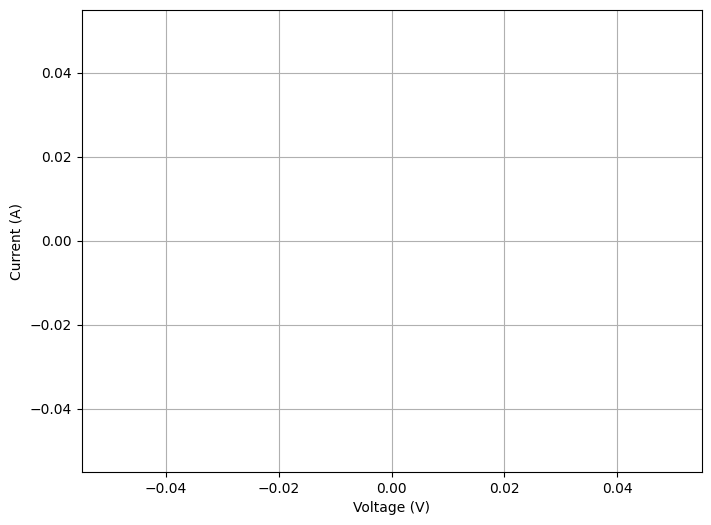

In [3]:
import os
import sys
import time
import csv
import numpy as np
import threading
import queue
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import tkinter as tk
from tkinter import ttk, messagebox, filedialog
import serial.tools.list_ports
import serial
from Keithley617 import Keithley617 as smu

class JVMeasurementApp:
    def __init__(self, master):
        self.master = master
        master.title("ScanDor JV Measurement")

        # Measurement parameters
        self.start_voltage = tk.DoubleVar(value=0)
        self.end_voltage = tk.DoubleVar(value=10)
        self.step_size = tk.DoubleVar(value=1)
        self.scan_rate = tk.DoubleVar(value=1)
        self.use_std_check = tk.BooleanVar(value=True)
        self.sample_number = tk.IntVar(value=5)
        self.max_samples = tk.IntVar(value=30)
        self.std_threshold = tk.DoubleVar(value=0.1)
        self.file_name = tk.StringVar(value="measurement_data")
        self.output_directory = tk.StringVar(value=os.getcwd())
        self.selected_port = tk.StringVar()
        self.sweep_mode = tk.StringVar(value='Directional Sweep')
        self.num_cycles = tk.IntVar(value=1)  # For Hysteresis mode
        self.constant_voltage = tk.DoubleVar(value=0)  # For Constant Voltage mode
        self.constant_runtime = tk.DoubleVar(value=10)  # For Constant Voltage mode runtime

        # Data arrays
        self.times = []
        self.currents = []
        self.voltages = []
        self.cycles = []

        # Instrument
        self.instrument = None  # Will hold the smu instance after connection

        # Matplotlib Figure
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.line, = self.ax.plot([], [], 'b-o')
        self.ax.set_xlabel('Voltage (V)')
        self.ax.set_ylabel('Current (A)')
        self.ax.grid(True)

        # Create GUI elements
        self.create_widgets()

        # Queue for thread-safe communication
        self.data_queue = queue.Queue()

        # Flag to stop the measurement thread if needed
        self.stop_measurement = False

    def create_widgets(self):
        # Use ttk for nicer looking widgets
        style = ttk.Style()
        style.theme_use('default')

        # Sweep Mode Selection at the top
        ttk.Label(self.master, text="Sweep Mode:").grid(row=0, column=0, sticky='e')
        sweep_modes = ['Directional Sweep', '0 Centered Sweep',
                       'Hysteresis', 'Constant Voltage']
        self.sweep_mode_combo = ttk.Combobox(self.master, textvariable=self.sweep_mode, values=sweep_modes, state='readonly')
        self.sweep_mode_combo.grid(row=0, column=1)
        self.sweep_mode_combo.bind('<<ComboboxSelected>>', self.update_sweep_mode_fields)

        # ASCII Diagram Label
        self.ascii_diagram = tk.StringVar()
        self.update_ascii_diagram()
        ttk.Label(self.master, textvariable=self.ascii_diagram, justify='center').grid(row=1, column=0, columnspan=2)

        # Additional parameters for certain sweep modes (moved here)
        self.additional_params_frame = ttk.Frame(self.master)
        self.additional_params_frame.grid(row=2, column=0, columnspan=2, sticky='w')
        self.update_sweep_mode_fields()

        # Serial Port Selection
        ttk.Label(self.master, text="Select Source-Measure Unit USB Port:").grid(row=3, column=0, sticky='e')
        self.port_combo = ttk.Combobox(self.master, textvariable=self.selected_port, values=self.get_serial_ports(), state='readonly')
        self.port_combo.grid(row=3, column=1)
        if self.port_combo['values']:
            self.port_combo.current(0)

        # Connect Button
        self.connect_button = ttk.Button(self.master, text="Connect", command=self.connect_instrument)
        self.connect_button.grid(row=4, column=0, columnspan=2, pady=5)

        # Connection Status
        self.connection_status = tk.StringVar(value="Not Connected")
        ttk.Label(self.master, textvariable=self.connection_status).grid(row=5, column=0, columnspan=2)

        # Measurement Parameters
        ttk.Label(self.master, text="Start Voltage (V):").grid(row=6, column=0, sticky='e')
        self.start_voltage_entry = ttk.Entry(self.master, textvariable=self.start_voltage)
        self.start_voltage_entry.grid(row=6, column=1)

        ttk.Label(self.master, text="End Voltage (V):").grid(row=7, column=0, sticky='e')
        self.end_voltage_entry = ttk.Entry(self.master, textvariable=self.end_voltage)
        self.end_voltage_entry.grid(row=7, column=1)

        ttk.Label(self.master, text="Step Size (V):").grid(row=8, column=0, sticky='e')
        self.step_size_entry = ttk.Entry(self.master, textvariable=self.step_size)
        self.step_size_entry.grid(row=8, column=1)

        ttk.Label(self.master, text="Scan Rate (V/s):").grid(row=9, column=0, sticky='e')
        self.scan_rate_entry = ttk.Entry(self.master, textvariable=self.scan_rate)
        self.scan_rate_entry.grid(row=9, column=1)

        # Standard Deviation Check
        self.std_check_button = ttk.Checkbutton(self.master, text="Use Standard Deviation Check", variable=self.use_std_check, command=self.toggle_std_check)
        self.std_check_button.grid(row=10, columnspan=2)

        ttk.Label(self.master, text="Sample Number:").grid(row=11, column=0, sticky='e')
        self.sample_number_entry = ttk.Entry(self.master, textvariable=self.sample_number)
        self.sample_number_entry.grid(row=11, column=1)

        ttk.Label(self.master, text="Max Samples:").grid(row=12, column=0, sticky='e')
        self.max_samples_entry = ttk.Entry(self.master, textvariable=self.max_samples)
        self.max_samples_entry.grid(row=12, column=1)

        ttk.Label(self.master, text="Standard Deviation Threshold:").grid(row=13, column=0, sticky='e')
        self.std_threshold_entry = ttk.Entry(self.master, textvariable=self.std_threshold)
        self.std_threshold_entry.grid(row=13, column=1)

        # Grey out std check parameters if not enabled
        self.toggle_std_check()

        ttk.Label(self.master, text="File Name:").grid(row=14, column=0, sticky='e')
        ttk.Entry(self.master, textvariable=self.file_name).grid(row=14, column=1)

        # Output Directory Selection
        ttk.Label(self.master, text="Output Directory:").grid(row=15, column=0, sticky='e')
        dir_frame = ttk.Frame(self.master)
        dir_frame.grid(row=15, column=1, sticky='w')
        self.dir_label = ttk.Label(dir_frame, textvariable=self.output_directory, width=30)
        self.dir_label.pack(side='left')
        ttk.Button(dir_frame, text="Browse", command=self.browse_directory).pack(side='left')

        # Start and Cancel Buttons
        button_frame = ttk.Frame(self.master)
        button_frame.grid(row=16, columnspan=2, pady=10)
        self.start_button = ttk.Button(button_frame, text="Start Measurement", command=self.start_measurement, state='disabled')
        self.start_button.pack(side='left', padx=5)
        self.cancel_button = ttk.Button(button_frame, text="Cancel Measurement", command=self.cancel_measurement, state='disabled')
        self.cancel_button.pack(side='left', padx=5)

        # Live Plot Canvas
        self.canvas = FigureCanvasTkAgg(self.fig, master=self.master)
        self.canvas.get_tk_widget().grid(row=17, columnspan=2)
        self.canvas.draw()

    def update_ascii_diagram(self):
        mode = self.sweep_mode.get()
        if mode == 'Directional Sweep':
            diagram = "Start --> End"
        elif mode == '0 Centered Sweep':
            diagram = "0 --> Start, 0 --> End"
        elif mode == 'Hysteresis':
            diagram = "0 --> Start --> End --> 0 (Repeat)"
        elif mode == 'Constant Voltage':
            diagram = "Constant Voltage"
        else:
            diagram = ""
        self.ascii_diagram.set(diagram)

    def toggle_std_check(self):
        if self.use_std_check.get():
            self.sample_number_entry.state(['!disabled'])
            self.max_samples_entry.state(['!disabled'])
            self.std_threshold_entry.state(['!disabled'])
        else:
            self.sample_number_entry.state(['disabled'])
            self.max_samples_entry.state(['disabled'])
            self.std_threshold_entry.state(['disabled'])

    def update_sweep_mode_fields(self, event=None):
        # Update ASCII diagram
        self.update_ascii_diagram()

        # Clear previous widgets
        for widget in self.additional_params_frame.winfo_children():
            widget.destroy()

        mode = self.sweep_mode.get()

        # Set default start and end voltages based on mode
        if mode == 'Directional Sweep':
            self.start_voltage.set(-10)
            self.end_voltage.set(10)
        elif mode == '0 Centered Sweep' or mode == 'Hysteresis':
            self.start_voltage.set(10)
            self.end_voltage.set(-10)
        else:
            # For Constant Voltage, we might not need to set start and end voltage
            pass

        if mode == 'Hysteresis':
            ttk.Label(self.additional_params_frame, text="Number of Cycles:").grid(row=0, column=0, sticky='e')
            ttk.Entry(self.additional_params_frame, textvariable=self.num_cycles).grid(row=0, column=1)
        elif mode == 'Constant Voltage':
            ttk.Label(self.additional_params_frame, text="Constant Voltage (V):").grid(row=0, column=0, sticky='e')
            ttk.Entry(self.additional_params_frame, textvariable=self.constant_voltage).grid(row=0, column=1)
            ttk.Label(self.additional_params_frame, text="Runtime (s):").grid(row=1, column=0, sticky='e')
            ttk.Entry(self.additional_params_frame, textvariable=self.constant_runtime).grid(row=1, column=1)

    def get_serial_ports(self):
        ports = serial.tools.list_ports.comports()
        port_list = [f"{port.device} - {port.description}" for port in ports]
        return port_list

    def browse_directory(self):
        directory = filedialog.askdirectory(initialdir=self.output_directory.get())
        if directory:
            self.output_directory.set(directory)
            self.dir_label.config(text=directory)

    def connect_instrument(self):
        if not self.selected_port.get():
            messagebox.showerror("Port Error", "Please select a serial port.")
            return
        # Attempt to connect to the instrument
        try:
            port_info = self.selected_port.get()
            port_device = port_info.split(' - ')[0]
            # Try to open the serial port to check permissions
            ser = serial.Serial(port_device)
            ser.close()
            # Now instantiate the smu class
            self.instrument = smu(port_device)
            self.connection_status.set("Connected")
            self.start_button.state(['!disabled'])
            self.connect_button.state(['disabled'])
            self.port_combo.state(['disabled'])
        except Exception as e:
            self.show_error("Connection Error", f"Failed to connect to Keithley 617: {e}")
            self.instrument = None
            self.connection_status.set("Not Connected")

    def start_measurement(self):
        if self.instrument is None:
            messagebox.showerror("Connection Error", "Instrument not connected.")
            return

        # Disable inputs during measurement
        for child in self.master.winfo_children():
            if isinstance(child, (ttk.Entry, ttk.Checkbutton, ttk.Button, ttk.Combobox)):
                child.state(['disabled'])

        # Enable the cancel button
        self.cancel_button.state(['!disabled'])

        # Collect parameters in main thread
        params = {
            'start_voltage': self.start_voltage.get(),
            'end_voltage': self.end_voltage.get(),
            'step_size': self.step_size.get(),
            'scan_rate': self.scan_rate.get(),
            'sample_number': self.sample_number.get(),
            'max_samples': self.max_samples.get(),
            'std_threshold': self.std_threshold.get(),
            'use_std_check': self.use_std_check.get(),
            'file_name': self.file_name.get(),
            'output_directory': self.output_directory.get(),
            'selected_port': self.selected_port.get(),
            'sweep_mode': self.sweep_mode.get(),
            'num_cycles': self.num_cycles.get(),
            'constant_voltage': self.constant_voltage.get(),
            'constant_runtime': self.constant_runtime.get()
        }

        # Reset data arrays
        self.times = []
        self.currents = []
        self.voltages = []
        self.cycles = []

        # Start measurement in a new thread
        self.stop_measurement = False
        measurement_thread = threading.Thread(target=self.measure, args=(params,))
        measurement_thread.start()

        # Start the periodic GUI update
        self.master.after(100, self.process_queue)

    def cancel_measurement(self):
        self.stop_measurement = True
        self.reset_gui()
        messagebox.showinfo("Measurement Cancelled", "The measurement has been cancelled.")

    def process_queue(self):
        try:
            while True:
                data = self.data_queue.get_nowait()
                if data == 'MEASUREMENT_COMPLETE':
                    # Re-enable inputs
                    self.reset_gui()
                    messagebox.showinfo("Measurement Complete", "The measurement has been completed successfully.")
                    return
                elif data == 'MEASUREMENT_ERROR':
                    self.reset_gui()
                    return
                else:
                    # Update plot with new data point
                    if len(data) == 4:
                        time_point, current, voltage, cycle_number = data
                        self.times.append(time_point)
                        self.currents.append(current)
                        self.voltages.append(voltage)
                        self.cycles.append(cycle_number)
                    else:
                        time_point, current, voltage = data
                        self.times.append(time_point)
                        self.currents.append(current)
                        self.voltages.append(voltage)
                        self.cycles.append(0)
                    self.update_plot()
        except queue.Empty:
            pass
        # Schedule the next queue check
        if not self.stop_measurement:
            self.master.after(100, self.process_queue)

    def measure(self, params):
        # Extract parameters
        start_voltage = params['start_voltage']
        end_voltage = params['end_voltage']
        step_size = params['step_size']
        scan_rate = params['scan_rate']
        sample_number = params['sample_number']
        max_samples = params['max_samples']
        std_threshold = params['std_threshold']
        use_std_check = params['use_std_check']
        file_name = params['file_name']
        output_directory = params['output_directory']
        selected_port = params['selected_port']
        sweep_mode = params['sweep_mode']
        num_cycles = params['num_cycles']
        constant_voltage = params['constant_voltage']
        constant_runtime = params['constant_runtime']

        filename = os.path.join(output_directory, file_name + '.csv')

        # Generate the source_voltages array based on the sweep mode
        try:
            source_voltages, cycle_numbers = self.generate_voltage_sequence(
                sweep_mode, start_voltage, end_voltage, step_size, num_cycles,
                constant_voltage, constant_runtime, scan_rate)
        except Exception as e:
            self.data_queue.put('MEASUREMENT_ERROR')
            self.show_error("Voltage Sequence Error", f"Failed to generate voltage sequence: {e}")
            return

        # Total time and delay per step
        total_time = abs(end_voltage - start_voltage) / scan_rate if scan_rate != 0 else 0
        delay_time = total_time / len(source_voltages) if len(source_voltages) > 0 else 0

        # Initialize measurement
        instrument = self.instrument
        try:
            instrument.reading_mode('electrometer')
            instrument.zero_check('off')
            instrument.zero_correct('enabled')
            instrument.set_function('amps')
            instrument.data_format('without_prefix')
            instrument.set_range('R0')  # Auto range
            instrument.source_output('on')
        except Exception as e:
            self.data_queue.put('MEASUREMENT_ERROR')
            self.show_error("Instrument Error", f"Failed to initialize instrument: {e}")
            self.close_instrument()
            return

        start_time = time.perf_counter()

        for i, voltage in enumerate(source_voltages):
            if self.stop_measurement:
                break
            round_start = time.perf_counter()
            try:
                instrument.set_voltage(voltage)
            except Exception as e:
                self.data_queue.put('MEASUREMENT_ERROR')
                self.show_error("Instrument Error", f"Failed to set voltage: {e}")
                self.close_instrument()
                return

            # Standard deviation check
            if use_std_check:
                samples = []
                # Initial samples
                for _ in range(sample_number):
                    current = self.measure_current_with_retry(instrument)
                    if current is None:
                        continue
                    samples.append(current)

                measurement_count = sample_number
                while True:
                    if self.stop_measurement:
                        break
                    if len(samples) >= sample_number:
                        std_dev = np.std(samples[-sample_number:])
                    else:
                        std_dev = np.std(samples)
                    if std_dev < std_threshold:
                        break
                    current = self.measure_current_with_retry(instrument)
                    if current is None:
                        continue
                    samples.append(current)
                    measurement_count += 1
                    if measurement_count > max_samples:
                        self.data_queue.put('MEASUREMENT_ERROR')
                        self.show_error("Measurement Error",
                                        f"Failed to achieve desired standard deviation at voltage {voltage} V.")
                        instrument.source_output('off')
                        self.close_instrument()
                        return
                if samples:
                    current = np.mean(samples[-sample_number:])
                else:
                    current = None
            else:
                current = None
                current = self.measure_current_with_retry(instrument)
                if current is None:
                    continue
            elapsed_time = time.perf_counter() - start_time

            # Get the cycle number (for plotting)
            if sweep_mode == 'Hysteresis':
                cycle_number = cycle_numbers[i]
            else:
                cycle_number = 0

            # Put the new data point into the queue
            self.data_queue.put((elapsed_time, current, voltage, cycle_number))

            # Delay to match scan rate
            elapsed_round = time.perf_counter() - round_start
            if (delay_time - elapsed_round) > 0:
                time.sleep(delay_time - elapsed_round)

        # Finish measurement
        instrument.source_output('off')

        # Save data
        self.save_data(filename)

        # Signal that measurement is complete
        self.data_queue.put('MEASUREMENT_COMPLETE')

    def generate_voltage_sequence(self, mode, start_voltage, end_voltage, step_size, num_cycles, constant_voltage, constant_runtime, scan_rate):
        if mode == 'Directional Sweep':
            if start_voltage > end_voltage:
                step_size = -abs(step_size)
            else:
                step_size = abs(step_size)
            source_voltages = np.arange(start_voltage, end_voltage + step_size, step_size)
            cycle_numbers = np.zeros(len(source_voltages), dtype=int)
        elif mode == '0 Centered Sweep':
            # Sweep from 0 to start_voltage
            if start_voltage != 0:
                if start_voltage > 0:
                    voltages1 = np.arange(0, start_voltage + step_size, step_size)
                else:
                    voltages1 = np.arange(0, start_voltage - step_size, -step_size)
            else:
                voltages1 = [0]
            # Sweep from 0 to end_voltage
            if end_voltage != 0:
                if end_voltage > 0:
                    voltages2 = np.arange(0, end_voltage + step_size, step_size)
                else:
                    voltages2 = np.arange(0, end_voltage - step_size, -step_size)
            else:
                voltages2 = [0]
            source_voltages = np.concatenate((voltages1, voltages2))
            cycle_numbers = np.zeros(len(source_voltages), dtype=int)
        elif mode == 'Hysteresis':
            # Start at 0, sweep to start_voltage, sweep to end_voltage, then back to 0, repeat n times
            source_voltages = []
            cycle_numbers = []
            for cycle in range(num_cycles):
                # Sweep from 0 to start_voltage
                if start_voltage != 0:
                    if start_voltage > 0:
                        sweep_to_start = np.arange(0, start_voltage + step_size, step_size)
                    else:
                        sweep_to_start = np.arange(0, start_voltage - step_size, -step_size)
                else:
                    sweep_to_start = [0]
                # Sweep from start_voltage to end_voltage
                if start_voltage > end_voltage:
                    step = -abs(step_size)
                else:
                    step = abs(step_size)
                sweep_to_end = np.arange(start_voltage + step, end_voltage + step, step)
                # Sweep from end_voltage back to 0
                if end_voltage != 0:
                    if end_voltage > 0:
                        sweep_back_to_0 = np.arange(end_voltage - step_size, -step_size, -step_size)
                    else:
                        sweep_back_to_0 = np.arange(end_voltage + step_size, step_size, step_size)
                else:
                    sweep_back_to_0 = [end_voltage]

                cycle_voltages = np.concatenate((sweep_to_start, sweep_to_end, sweep_back_to_0))
                source_voltages.extend(cycle_voltages)
                cycle_numbers.extend([cycle] * len(cycle_voltages))
            source_voltages = np.array(source_voltages)
            cycle_numbers = np.array(cycle_numbers)
        elif mode == 'Constant Voltage':
            # Maintain constant voltage for a runtime duration
            if scan_rate == 0:
                num_points = int(constant_runtime)
            else:
                num_points = int(constant_runtime * scan_rate)
            source_voltages = [constant_voltage] * num_points
            cycle_numbers = np.zeros(len(source_voltages), dtype=int)
        else:
            raise ValueError("Invalid sweep mode selected.")
        return source_voltages, cycle_numbers

    def measure_current_with_retry(self, instrument):
        for _ in range(3):  # Retry up to 3 times
            if self.stop_measurement:
                return None
            try:
                current = instrument.measure_current()
                if current is not None:
                    return current
            except Exception as e:
                print(f"Error measuring current: {e}")
            time.sleep(0.1)
        print("Failed to measure current after 3 attempts")
        return None

    def update_plot(self):
        self.ax.clear()
        self.ax.set_xlabel('Voltage (V)')
        self.ax.set_ylabel('Current (A)')
        self.ax.grid(True)
        if self.sweep_mode.get() == 'Hysteresis':
            unique_cycles = np.unique(self.cycles)
            colors = plt.cm.jet(np.linspace(0, 1, len(unique_cycles)))
            for idx, cycle in enumerate(unique_cycles):
                indices = [i for i, c in enumerate(self.cycles) if c == cycle]
                voltages = [self.voltages[i] for i in indices]
                currents = [self.currents[i] for i in indices]
                self.ax.plot(voltages, currents, color=colors[idx], label=f'Cycle {int(cycle)+1}')
            self.ax.legend()
        else:
            self.ax.plot(self.voltages, self.currents, 'b-o')
        self.canvas.draw()

    def save_data(self, filename):
        try:
            with open(filename, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['Time (s)', 'Current (A)', 'Voltage (V)', 'Cycle'])
                for i in range(len(self.times)):
                    csvwriter.writerow([self.times[i], self.currents[i], self.voltages[i], self.cycles[i]])
            # Save the plot
            plot_filename = os.path.splitext(filename)[0] + '.png'
            self.fig.savefig(plot_filename)
        except Exception as e:
            self.show_error("File Error", f"Could not save data or plot: {e}")

    def reset_gui(self):
        for child in self.master.winfo_children():
            if isinstance(child, (ttk.Entry, ttk.Checkbutton, ttk.Button, ttk.Combobox)):
                child.state(['!disabled'])
        self.cancel_button.state(['disabled'])
        self.stop_measurement = True  # Stop the measurement thread

    def show_error(self, title, message):
        # Schedule the messagebox to be shown in the main thread
        self.master.after(0, lambda: messagebox.showerror(title, message))

    def close_instrument(self):
        if self.instrument:
            try:
                self.instrument.disconnect()
            except Exception as e:
                print(f"Error disconnecting instrument: {e}")
            self.instrument = None
            self.connection_status.set("Not Connected")
            self.start_button.state(['disabled'])
            self.connect_button.state(['!disabled'])
            self.port_combo.state(['!disabled'])

    def on_closing(self):
        # Close instrument connection if open
        self.close_instrument()
        self.master.destroy()

# Run the application
if __name__ == "__main__":
    root = tk.Tk()
    app = JVMeasurementApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    root.mainloop()


In [4]:
import sys
from cx_Freeze import setup, Executable

base = None
if sys.platform == 'win32':
    base = 'Win32GUI'

executables = [Executable('JVMeasurementApp.py', base=base)]

setup(
    name='JVMeasurementApp',
    version='1.0',
    description='JV Measurement Application',
    executables=executables,
    options={
        'build_exe': {
            'packages': ['numpy', 'matplotlib', 'tkinter', 'serial'],
            'include_files': ['Keithley617']  # Adjust as necessary
        }
    }
)


SystemExit: usage: ipykernel_launcher.py [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
   or: ipykernel_launcher.py --help [cmd1 cmd2 ...]
   or: ipykernel_launcher.py --help-commands
   or: ipykernel_launcher.py cmd --help

error: option --fullname must not have an argument

/home/sauron/repos/SaidaminovLab/Keithley617/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
python setup.py build

SyntaxError: invalid syntax (4276232348.py, line 1)